### **Mount google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing the libraries**

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns # for data visualization 
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop #optimiers for optimizing the model
from keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
# from keras_pickle_wrapper import KerasPickleWrapper
# import pickle

### **Reading Data**

In [3]:
DATADIR = r"/content/drive/My Drive/AIML/computerVision/Assignment"
image_file = os.path.join(DATADIR,'images.npy')
label_file = os.path.join(DATADIR,'Labels.csv')
images = np.load(image_file)
labels = pd.read_csv(label_file)
CATEGORIES = labels.Label.unique()

In [4]:
# Check Shape of Image files and labels
print('Shape of the Images = ',images.shape)
print('Shape of the labels = ',labels.shape)

Shape of the Images =  (4750, 128, 128, 3)
Shape of the labels =  (4750, 1)


In [5]:
# from numpy.ma.core import where
# check if there are any nulls in the images nd Array
images[np.isnan(images)]

array([], dtype=uint8)



*   looks like images data is not having any nulls.



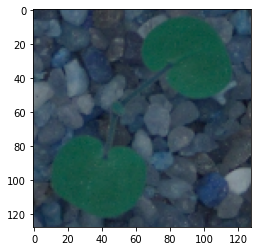

In [6]:
# visualize sample image
plt.imshow(images[100])
plt.show()

### **Data Preprocessing**

###### Apply Normalization

In [8]:
# Normalizing the pixels
X = images.astype(float)/255.0
# copying the lables to y variable
y = labels.Label

In [89]:
# check the unique number of labels
y.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [10]:
print(X.shape)

(4750, 128, 128, 3)



###### Apply Gaussian blurr



In [11]:
# apply Gaussian blurr
for idx, img in enumerate(X):
  X[idx] = cv2.GaussianBlur(img, (5, 5), 0)

before data preprocessing


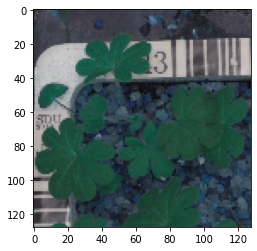

after applying gaussian blurr


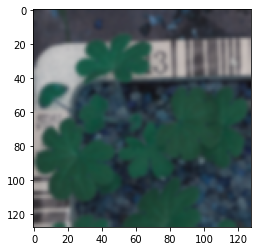

In [12]:
# check sample images after preprocessing
print('before data preprocessing')
plt.imshow(images[3])
plt.show()
print("after applying gaussian blurr")
plt.imshow(X[3], cmap='gray') 
plt.show()

###### Sample image from each lable

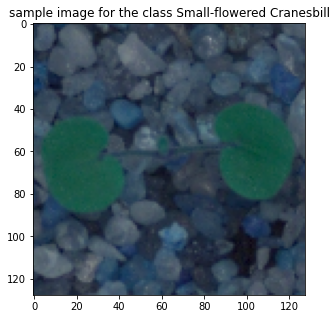

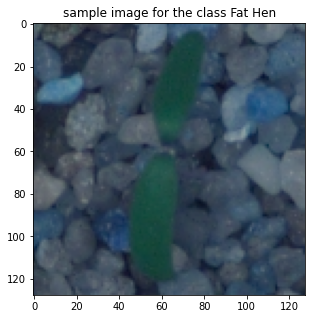

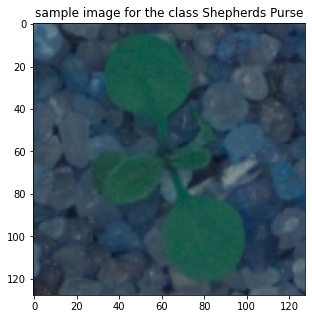

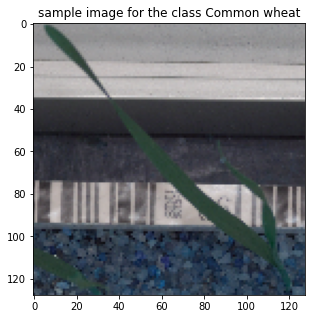

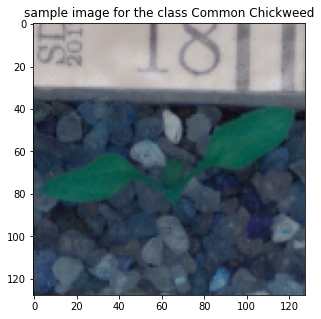

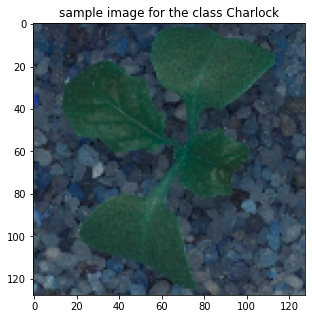

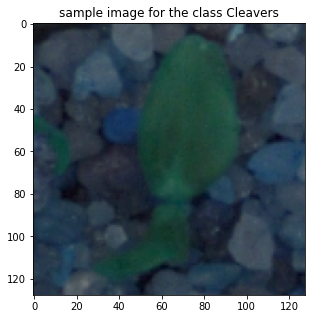

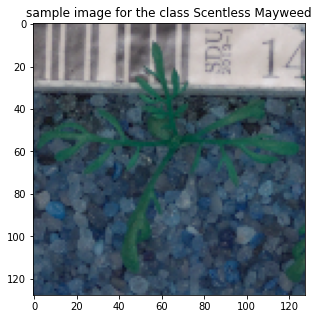

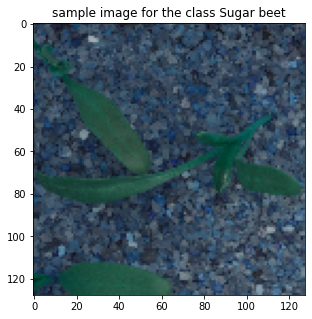

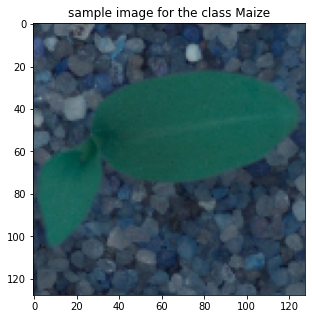

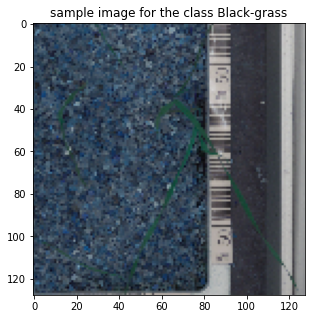

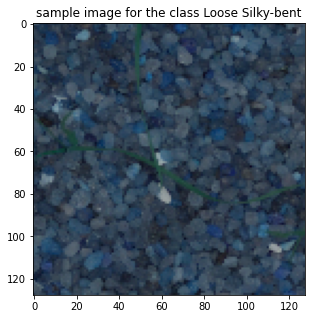

In [93]:

for cat in CATEGORIES:
  idx = list(labels.Label).index(cat) # get the index of the first occurance of the each class
  plt.figure(figsize=(10,5))
  plt.imshow(images[idx]) 
  plt.title("sample image for the class " + cat)
  plt.show()


### **Exploratory Data Analysis**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


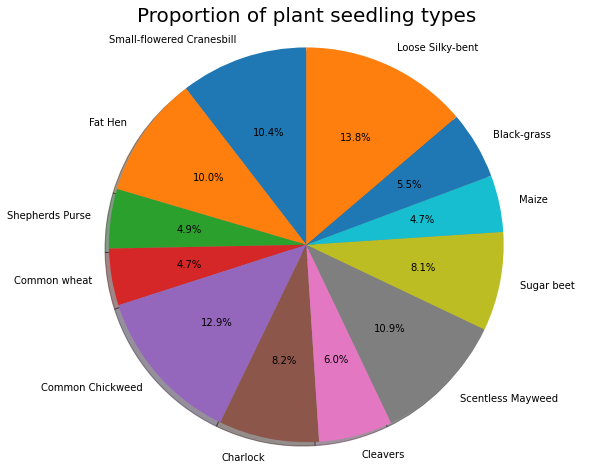

In [13]:
# draw pie chart for all types of plants seedlings
plant_types = y.unique()
counts = [labels[labels['Label']==plnt].count() for plnt in plant_types]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(counts, labels=plant_types, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of plant seedling types", size = 20)
plt.show()

##### Observation:


*   Majority of the plant seedlings are "Common Chickweed - 12.9%" and "Loose Silky Bent - 13.8%"
*   Remamining types are around and below 10%



### **Make data compatible**

###### Convert labels to one-hot-vectors

In [14]:
cat_map = {
	'Small-flowered Cranesbill':0,
	'Fat Hen':1,
	'Shepherds Purse':2,
	'Common wheat':3, 
	'Common Chickweed':4, 
	'Charlock':5, 
	'Cleavers':6,
	'Scentless Mayweed':7, 
	'Sugar beet':8, 
	'Maize':9,
	'Black-grass':10,
	'Loose Silky-bent':11
}
y = labels.Label.map(cat_map)
print(y.unique())
y_encoded = to_categorical(y)


[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [15]:
print(y_encoded.shape)

(4750, 12)


In [16]:
# print the first lable from the encoded set
print(y_encoded[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##### Split the data into train, test and validation

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [18]:
# check the size of train and test data sets
print('train set shapes ',X_train.shape, y_train.shape)
print('test set shapes ',X_test.shape, y_test.shape)

train set shapes  (3325, 128, 128, 3) (3325, 12)
test set shapes  (1425, 128, 128, 3) (1425, 12)


In [19]:
# lets further devide the test set in to test & validation sets
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [20]:
# check the size of test and validation data sets
print('validation set shapes ',X_validation.shape, y_validation.shape)
print('test set shapes ',X_test.shape, y_test.shape)

validation set shapes  (713, 128, 128, 3) (713, 12)
test set shapes  (712, 128, 128, 3) (712, 12)


**Reshaping is not required because the current shape of train, test and validation sets is 128 * 128 * 3 which is compatible with Keras models.**

In [21]:
# check the shapes before building the model
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(3325, 128, 128, 3)
(712, 128, 128, 3)
(713, 128, 128, 3)


### **Building CNN**

Build model with basic parameters

In [96]:
# build and compile the models with callbacks
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) # check point to save the model
model0 = Sequential()
#
model0.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model0.add(keras.layers.MaxPooling2D((2, 2)))
#
model0.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model0.add(keras.layers.MaxPooling2D((2, 2)))

#
model0.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model0.add(keras.layers.MaxPooling2D((2, 2)))

model0.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

# 
model0.add(Flatten())
model0.add(Dense(512, activation = "relu"))
model0.add(Dense(256, activation = "relu"))
model0.add(Dense(12, activation = "softmax"))
model0.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [97]:
# check model summary
model0.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)       

In [98]:
history0=model0.fit(X_train, 
          y_train,  #It expects integers because of the sparse_categorical_crossentropy loss function
          epochs=50, #number of iterations over the entire dataset to train on
          batch_size=10,validation_data=(X_validation,y_validation),callbacks=[mc],use_multiprocessing=True)


Epoch 1/50
333/333 [==============================] - 4s 11ms/step - loss: 2.1995 - accuracy: 0.2286 - val_loss: 1.6299 - val_accuracy: 0.4151

Epoch 00001: val_accuracy improved from -inf to 0.41515, saving model to best_model.h5
Epoch 2/50
333/333 [==============================] - 3s 9ms/step - loss: 1.4309 - accuracy: 0.4995 - val_loss: 1.1142 - val_accuracy: 0.6213

Epoch 00002: val_accuracy improved from 0.41515 to 0.62132, saving model to best_model.h5
Epoch 3/50
333/333 [==============================] - 3s 9ms/step - loss: 0.9341 - accuracy: 0.6743 - val_loss: 0.9710 - val_accuracy: 0.6620

Epoch 00003: val_accuracy improved from 0.62132 to 0.66199, saving model to best_model.h5
Epoch 4/50
333/333 [==============================] - 3s 9ms/step - loss: 0.6821 - accuracy: 0.7663 - val_loss: 0.9409 - val_accuracy: 0.6760

Epoch 00004: val_accuracy improved from 0.66199 to 0.67602, saving model to best_model.h5
Epoch 5/50
333/333 [==============================] - 3s 9ms/step - lo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


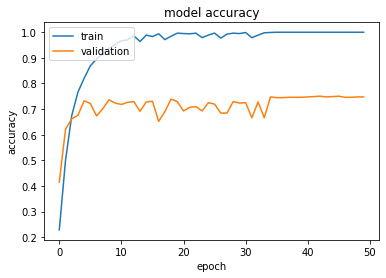

In [99]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history0.history['accuracy'])
plt.plot(history0.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

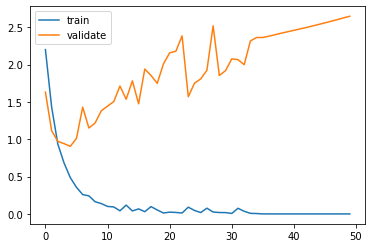

In [100]:
# summarize loss
plt.plot(history0.history['loss'], label='train')
plt.plot(history0.history['val_loss'], label='validate')
plt.legend()
plt.show()

###### Seems like the basic model is overfitting. Training score is 100% and test score  is 75%. Lets try to improve the model by using drop outs, Batch normalization and other hyper parameters

Build CNN with drop out, Batch normalization & Early stopping

In [30]:
# build and compile the models with callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) # check point to save the model
model = Sequential()
#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
#model.add(keras.layers.Dropout(0.1))
#
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.5))

# 
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(256, activation = "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [31]:
# check model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)       

### **Fit and Evaluate the Model**

In [32]:
# fit the model
history=model.fit(X_train, 
          y_train,  #It expects integers because of the sparse_categorical_crossentropy loss function
          epochs=100, #number of iterations over the entire dataset to train on
          batch_size=32,validation_data=(X_validation,y_validation),callbacks=[mc,es],use_multiprocessing=True)


Epoch 1/100
104/104 [==============================] - 4s 25ms/step - loss: 4.0882 - accuracy: 0.0878 - val_loss: 2.4749 - val_accuracy: 0.1346

Epoch 00001: val_accuracy improved from -inf to 0.13464, saving model to best_model.h5
Epoch 2/100
104/104 [==============================] - 2s 20ms/step - loss: 2.8718 - accuracy: 0.1284 - val_loss: 2.5408 - val_accuracy: 0.1346

Epoch 00002: val_accuracy did not improve from 0.13464
Epoch 3/100
104/104 [==============================] - 2s 20ms/step - loss: 2.5604 - accuracy: 0.1732 - val_loss: 2.5645 - val_accuracy: 0.1346

Epoch 00003: val_accuracy did not improve from 0.13464
Epoch 4/100
104/104 [==============================] - 2s 20ms/step - loss: 2.4499 - accuracy: 0.1817 - val_loss: 2.4852 - val_accuracy: 0.1346

Epoch 00004: val_accuracy did not improve from 0.13464
Epoch 5/100
104/104 [==============================] - 2s 20ms/step - loss: 2.3392 - accuracy: 0.2150 - val_loss: 2.3047 - val_accuracy: 0.1571

Epoch 00005: val_accura

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


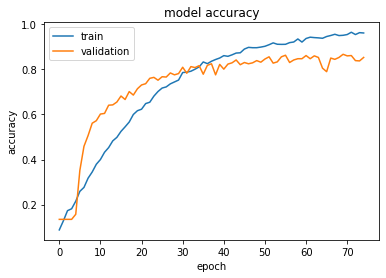

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

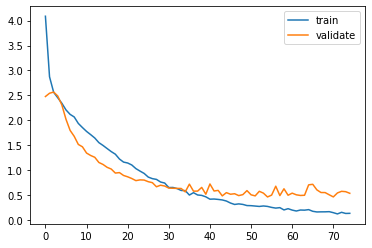

In [34]:
# summarize loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend()
plt.show()

###### Seems like this model is better compared to previous model its less over fitting. 

###### **Evaluation**

In [35]:
# Evaluate the model on Test set
model.evaluate(X_test,y_test)

23/23 [==============================] - 0s 9ms/step - loss: 0.6180 - accuracy: 0.8624


[0.6179580092430115, 0.8623595237731934]

In [37]:
# get predictions
preds = model.predict(X_test)

In [61]:
# get the labels for predictions and actuals for comparision
predictions = [CATEGORIES[np.argmax(pred)] for pred in preds]
Actuals = [CATEGORIES[np.argmax(act)] for act in y_test]

###### Confusion Metrics

In [81]:
# Model accuracy on test set  
score = accuracy_score(np.array(Actuals), np.array(predictions))
print('Model accuracy on test set  is {}'.format(score))

Model accuracy on test set  is 0.8623595505617978


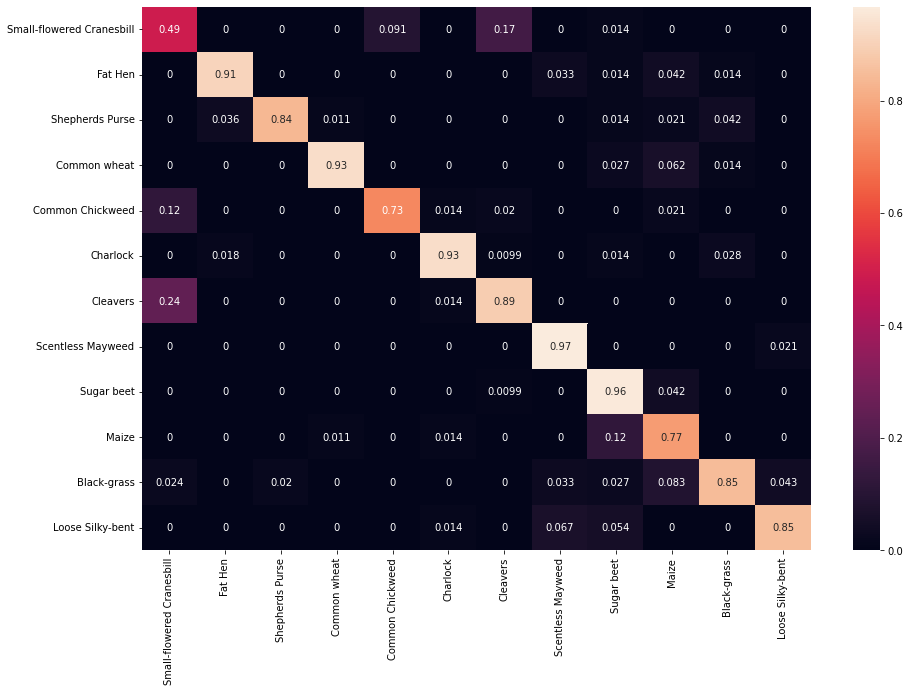

In [85]:
cf_matrix = confusion_matrix(np.array(Actuals), np.array(predictions))

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)

### **Visualize the predictions**

In [39]:
print(preds.shape)
print(y_test.shape)

(712, 12)
(712, 12)


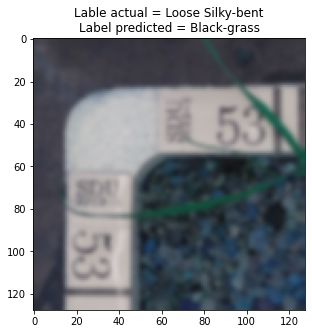

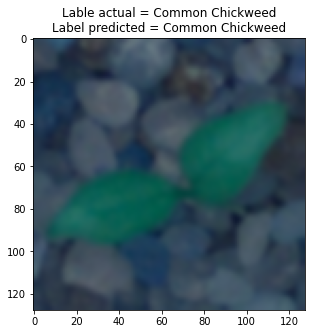

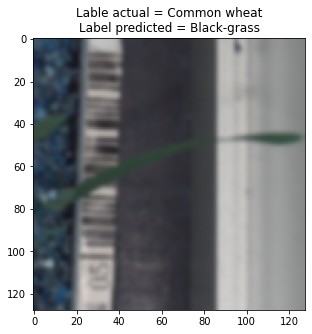

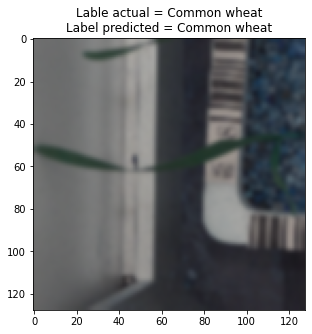

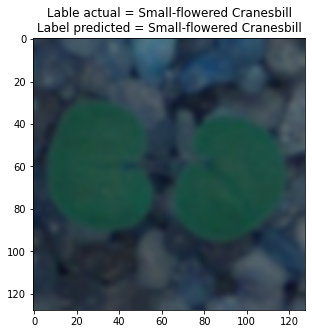

In [77]:
# Visualize for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]
test_images = [2,3,33,36,59] # created a list for test image indices
for test_image in test_images:
  plt.figure(figsize=(10,5))
  plt.imshow(X_test[test_image]) 
  title = 'Lable actual = '+Actuals[test_image]+'\nLabel predicted = '+predictions[test_image]
  plt.title(title)
  plt.show()
  print('\n')



### **Conclusion**

* Basic model was over fitting. Hence improved model by adding drop out layer , batch normalization and other hyper parameters. The improved model is far better than the basic model. 
* Both Validation score and Test set scores are almost same 86% from improved model. Training set score is 96%.
* The improvred model was able to predict 3 images correctly out of 5 given test images. Since the model has an accuracy around 86% on test set, one should expect incorrect classifications with other images.




